<a href="https://colab.research.google.com/github/youavang/inaugural_speech_nlp/blob/main/NLP_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling

In this notebook we'll try topic modeling with **Latent Dirichlet Allocation (LDA)**. The purpose of topic modeling is to find various topics that are present in your corpus. Each document in the corpus will be made up of at least one topic, if not multiple topics.

In [1]:
# Mount to Google Drive to access saved files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Topic Modeling - All Text

In [2]:
# Let's read in our document-term matrix
import pandas as pd
import pickle

data = pd.read_pickle('/content/drive/MyDrive/pickle/dtm_stop.pkl')
data

,abandoned,abandonment,ability,able,abroad,abuse,accept,accomplishment,account,accumulate,achieve,achieved,act,action,acts,address,administered,administration,advance,advancing,advantage,adversaries,affairs,affect,affirm,afford,afghanistan,age,ages,aggression,ago,agree,aid,aids,aims,airports,alarmed,allegiance,alliances,allies,...,weve,whip,whirlwind,whisper,white,wield,william,willing,willingness,win,wind,winds,windswept,winning,winter,wisdom,wisely,woman,women,wonderful,wonders,woolley,words,worked,workers,working,works,worldly,worlds,wornout,worry,wounded,wrong,wrote,year,years,yes,yesterdays,yielding,young
bush,0,1,0,0,0,1,1,1,0,1,0,1,0,0,2,2,1,0,1,0,0,0,0,0,3,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,...,0,0,2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,1,0,2,0,0,1,1
clinton,0,0,0,1,1,0,0,0,0,0,0,0,2,0,0,2,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,2,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,2,0,1,0,1,0,0,0,1,1,0,2
obama,1,0,1,0,0,0,1,0,1,0,1,0,1,1,0,2,1,0,1,1,0,1,0,0,0,2,1,2,1,0,1,0,0,0,1,0,1,0,1,0,...,0,1,0,1,0,1,0,2,2,0,0,1,0,0,2,0,1,1,4,0,1,1,4,1,2,0,1,1,1,1,0,0,1,0,2,1,1,0,0,1
trump,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,2,1,0,...,3,0,0,0,1,0,0,0,0,0,0,0,1,2,0,1,0,0,2,1,0,1,1,0,2,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1


In [3]:
# Import the necessary modules for LDA with gensim

from gensim import matutils, models, corpora
import scipy.sparse

In [4]:
# One of the required inputs is a term-document matrix
tdm = data.transpose()
tdm.head()

,bush,clinton,obama,trump
abandoned,0,0,1,0
abandonment,1,0,0,0
ability,0,0,1,0
able,0,1,0,0
abroad,0,1,0,0


In [5]:
# We're going to put the term-document matrix into a new gensim format, from df --> sparse matrix --> gensim corpus
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [6]:
# Gensim also requires dictionary of the all terms and their respective location in the term-document matrix
cv = pickle.load(open("/content/drive/MyDrive/pickle/cv_stop.pkl", "rb"))
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

Now that we have the corpus (term-document matrix) and id2word (dictionary of location: term), we need to specify two other parameters - the number of topics and the number of passes.

In [146]:
# Now that we have the corpus (term-document matrix) and id2word (dictionary of location: term),
# we need to specify two other parameters as well - the number of topics and the number of passes
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=1000)
lda.print_topics()

[(0,
  '0.004*"spirit" + 0.003*"come" + 0.003*"long" + 0.003*"words" + 0.003*"meet" + 0.003*"end" + 0.003*"women" + 0.003*"men" + 0.003*"seek" + 0.003*"oath"'),
 (1,
  '0.009*"story" + 0.005*"promise" + 0.005*"justice" + 0.005*"courage" + 0.005*"freedom" + 0.004*"live" + 0.004*"children" + 0.004*"public" + 0.004*"best" + 0.004*"ideals"'),
 (2,
  '0.007*"great" + 0.006*"right" + 0.006*"protected" + 0.006*"dreams" + 0.005*"bring" + 0.005*"god" + 0.005*"thank" + 0.005*"jobs" + 0.005*"heart" + 0.005*"wealth"'),
 (3,
  '0.009*"change" + 0.005*"fellow" + 0.005*"idea" + 0.004*"americas" + 0.004*"service" + 0.004*"democracy" + 0.004*"season" + 0.004*"renewal" + 0.003*"challenges" + 0.003*"way"')]

These topics aren't looking too great. We'll try looking only at terms that are from one part of speech (only nouns, only adjectives, etc.). 

## Topic Modeling - Nouns Only

In [8]:
# Let's create a function to pull out nouns from a string of text
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [9]:
# Read in the cleaned data, before the CountVectorizer step
data_clean = pd.read_pickle('/content/drive/MyDrive/pickle/data_clean.pkl')
data_clean

,transcript
bush,thank you all chief justice rehnquist presiden...
clinton,my fellow citizens today we celebrate the myst...
obama,my fellow citizens i stand here today humbled ...
trump,chief justice roberts president carter preside...


In [10]:
# Apply the nouns function to the transcripts to filter only on nouns
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [11]:
data_nouns = pd.DataFrame(data_clean.transcript.apply(nouns))
data_nouns

,transcript
bush,thank justice rehnquist president carter presi...
clinton,citizens today mystery renewal ceremony depth ...
obama,citizens today task trust mindful sacrifices a...
trump,justice roberts president carter president cli...


In [12]:
# Create a new document-term matrix using only nouns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

# Re-add the additional stop words since we are recreating the document-term matrix
add_stop_words = ['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said', 'let']

stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate a document-term matrix with only nouns
cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(data_nouns.transcript)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())
data_dtmn.index = data_nouns.index
data_dtmn

,abandonment,ability,abuse,accomplishment,action,acts,address,administration,advantage,adversaries,affairs,afghanistan,age,ages,aggression,aid,aims,airports,allegiance,alliances,allies,almighty,ambition,ambitions,america,americans,americas,ancestors,angel,animosities,answer,arguments,arlington,armies,arms,arrogance,attacks,author,authority,backgrounds,...,voices,votes,wage,wages,war,washington,waters,way,ways,weakness,wealth,wealthy,weapons,week,welfare,west,weve,whip,whirlwind,whisper,wield,william,willingness,wind,winds,winter,wisdom,woman,women,wonders,words,work,workers,world,worlds,wornout,worry,year,years,yesterdays
bush,1,0,1,1,0,2,2,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,7,5,1,0,2,0,0,0,0,0,0,1,1,1,1,1,...,0,0,0,0,1,0,0,2,1,1,0,0,1,0,0,0,0,0,2,0,0,1,0,1,0,0,0,0,0,0,0,3,0,3,0,0,0,0,2,0
clinton,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,6,8,1,0,0,1,0,0,0,0,1,0,0,0,1,0,...,1,1,0,1,2,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,1,0,1,3,0,18,2,0,1,0,0,1
obama,0,1,0,0,1,0,2,0,0,1,0,1,2,1,0,0,1,0,0,1,0,0,0,2,7,3,0,1,0,0,2,1,1,0,0,0,0,0,0,0,...,0,0,1,0,2,0,2,2,1,1,2,0,0,1,0,2,0,1,0,1,1,0,2,0,1,2,0,1,4,1,4,4,2,6,1,1,0,2,1,0
trump,0,0,0,0,2,0,2,1,0,0,1,0,0,0,0,1,0,1,2,1,0,1,0,0,11,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,2,0,2,0,0,4,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,2,0,1,0,2,6,0,0,0,0,2,0


In [13]:
# Create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))

# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [145]:
# Let's try 4 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=4, id2word=id2wordn, passes=1000)
ldan.print_topics()

[(0,
  '0.015*"country" + 0.015*"story" + 0.014*"nation" + 0.012*"america" + 0.010*"citizens" + 0.010*"president" + 0.009*"courage" + 0.009*"justice" + 0.009*"nations" + 0.009*"americans"'),
 (1,
  '0.032*"world" + 0.018*"today" + 0.014*"americans" + 0.011*"america" + 0.009*"idea" + 0.009*"nation" + 0.007*"service" + 0.007*"generation" + 0.007*"government" + 0.007*"democracy"'),
 (2,
  '0.021*"america" + 0.017*"country" + 0.013*"president" + 0.011*"nation" + 0.011*"world" + 0.010*"nations" + 0.010*"dreams" + 0.008*"jobs" + 0.008*"citizens" + 0.008*"heart"'),
 (3,
  '0.016*"nation" + 0.010*"today" + 0.010*"america" + 0.008*"world" + 0.007*"spirit" + 0.007*"generation" + 0.007*"day" + 0.006*"words" + 0.006*"women" + 0.006*"men"')]

## Topic Modeling - Nouns and Adjectives

In [15]:
# Let's create a function to pull out nouns from a string of text
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [16]:
# Apply the nouns function to the transcripts to filter only on nouns
data_nouns_adj = pd.DataFrame(data_clean.transcript.apply(nouns_adj))
data_nouns_adj

,transcript
bush,thank chief justice rehnquist president carter...
clinton,fellow citizens today mystery american renewal...
obama,fellow citizens i today task trust mindful sac...
trump,chief justice roberts president carter preside...


In [17]:
# Create a new document-term matrix using only nouns and adjectives, also remove common words with max_df
cvna = CountVectorizer(stop_words=stop_words, max_df=.8)
data_cvna = cvna.fit_transform(data_nouns_adj.transcript)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adj.index
data_dtmna

,abandonment,ability,able,abuse,accept,accomplishment,action,acts,administration,advantage,adversaries,affairs,afghanistan,age,ages,aggression,aid,aims,airports,allegiance,alliances,allies,almighty,ambition,ambitions,ancestors,ancient,angel,animosities,answer,apathy,arguments,arlington,armies,arms,arrogance,attacks,author,authority,backgrounds,...,washington,watchful,waters,ways,weakness,wealth,wealthy,weapons,weary,week,welfare,weve,whip,whirlwind,whisper,white,wield,william,willing,willingness,wind,winds,windswept,winter,wisdom,woman,women,wonderful,wonders,words,work,workers,worldly,worlds,wornout,worry,wrong,year,years,yesterdays
bush,1,0,0,1,0,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,2,0,0,1,0,0,0,0,1,1,1,1,1,...,0,0,0,1,1,0,0,1,0,0,0,0,0,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,0,2,0
clinton,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,1,3,0,0,2,0,1,1,0,0,1
obama,0,1,0,0,0,0,1,0,0,0,1,0,1,2,1,0,0,1,0,0,1,0,0,0,2,1,0,0,0,2,0,1,1,0,0,0,0,0,0,0,...,0,1,2,1,1,2,0,0,0,1,0,0,1,0,1,0,1,0,2,2,0,1,0,2,0,1,4,0,1,4,4,2,1,1,1,0,1,2,1,0
trump,0,0,0,0,1,0,2,0,1,0,0,1,0,0,0,0,1,0,1,2,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,2,0,0,0,0,4,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,2,1,0,1,0,2,0,0,0,0,0,0,2,0


In [101]:
# Create the gensim corpus
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [144]:
# LDA model
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=1000)
ldana.print_topics()

[(0,
  '0.009*"nations" + 0.009*"dreams" + 0.008*"jobs" + 0.008*"heart" + 0.008*"wealth" + 0.008*"day" + 0.006*"united" + 0.006*"families" + 0.006*"thank" + 0.006*"foreign"'),
 (1,
  '0.009*"idea" + 0.007*"generation" + 0.007*"service" + 0.007*"democracy" + 0.007*"millions" + 0.007*"change" + 0.007*"renewal" + 0.007*"season" + 0.006*"challenges" + 0.006*"sacrifice"'),
 (2,
  '0.015*"story" + 0.008*"nations" + 0.008*"common" + 0.007*"public" + 0.007*"best" + 0.007*"freedom" + 0.007*"ideals" + 0.007*"character" + 0.007*"duty" + 0.007*"civility"'),
 (3,
  '0.008*"common" + 0.006*"generation" + 0.006*"day" + 0.005*"words" + 0.005*"women" + 0.005*"men" + 0.005*"crisis" + 0.005*"greater" + 0.005*"peace" + 0.005*"work"')]

# Model Analysis
We are going to analyze how good each LDA model is by comparing their perplexity. The smaller this value the better the model.

In [147]:
# Get perplexity of each model

print('Perplexity of LDA Model: ', lda.log_perplexity(corpus))
print('\nPerplexity of LDA Model of Noun: ', ldan.log_perplexity(corpusn))
print('\nPerplexity of LDA Model of Noun + Adj: ', ldana.log_perplexity(corpusna))

Perplexity of LDA Model:  -7.531371005644132

Perplexity of LDA Model of Noun:  -6.683515116070094

Perplexity of LDA Model of Noun + Adj:  -7.044924226921065


The model with the smallest perplexity is the LDA model of nouns only. We want a model with perplexity as close to zero as possible.

## Identify which topic best fit an inaugural speech.

In [ ]:
# The best model
ldan = models.LdaModel(corpus=corpusn, num_topics=4, id2word=id2wordn, passes=1000)
ldan.print_topics()

[(0,
  '0.015*"country" + 0.015*"story" + 0.014*"nation" + 0.012*"america" + 0.010*"citizens" + 0.010*"president" + 0.009*"courage" + 0.009*"justice" + 0.009*"nations" + 0.009*"americans"'),
 (1,
  '0.032*"world" + 0.018*"today" + 0.014*"americans" + 0.011*"america" + 0.009*"idea" + 0.009*"nation" + 0.007*"service" + 0.007*"generation" + 0.007*"government" + 0.007*"democracy"'),
 (2,
  '0.021*"america" + 0.017*"country" + 0.013*"president" + 0.011*"nation" + 0.011*"world" + 0.010*"nations" + 0.010*"dreams" + 0.008*"jobs" + 0.008*"citizens" + 0.008*"heart"'),
 (3,
  '0.016*"nation" + 0.010*"today" + 0.010*"america" + 0.008*"world" + 0.007*"spirit" + 0.007*"generation" + 0.007*"day" + 0.006*"words" + 0.006*"women" + 0.006*"men"')]

In [148]:
# Let's take a look at which topics best fit which inaugural speech.
corpus_transformed = ldan[corpusn]
list(zip([a for [(a,b)] in corpus_transformed], data_dtmna.index))

[(0, 'bush'), (1, 'clinton'), (3, 'obama'), (2, 'trump')]

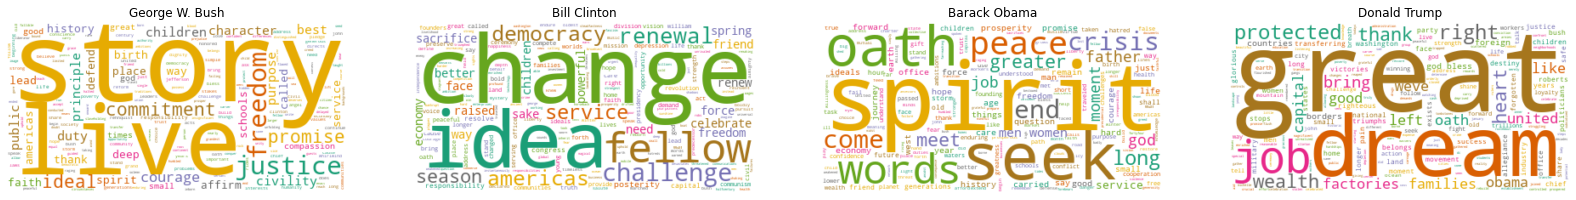

In [ ]:
# These are the word cloud that was generated during script analysis.

## Key word in each topic
We can find the key word in a topic that the model may think it matches a certain president by comparing the topics and the word cloud.


* Topic 0: [George W. Bush] <b>story</b>
* Topic 1: [Bill Clinton] <b>idea</b> 
* Topic 2: [Donald Trump] <b>dream</b> 
* Topic 3: [Barack Obama] <b>spirit</b> 